In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from typing import Tuple, Dict, List

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

In [10]:
# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

image_path = folder_path / "export"
# annotations
an_df = pd.read_csv(folder_path / "_annotations.csv")

an_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291,247,370,331
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270,235,293,321
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0,266,13,327
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25,258,106,304
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111,259,135,289
...,...,...,...,...,...,...,...,...
194534,1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...,512,512,car,369,236,415,271
194535,1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...,512,512,car,408,233,448,265
194536,1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...,512,512,car,177,274,188,286
194537,1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...,512,512,car,150,270,167,295


The images with no "class" (i.e. an empty road) are not included in the dataframe.

In [12]:
# get unincluded file names
folder_files = set(os.listdir(image_path))

# file names in an_df
df_files = set(an_df['filename'])

# missing files
missing_files = folder_files - df_files

len(missing_files)

3500

In [13]:
missing_df = pd.DataFrame(missing_files, columns=['filename'])

missing_df['width'] = 512
missing_df['height'] = 512
missing_df['class'] = "empty"

missing_df.head()

,filename,width,height,class
0,1478895674384327663_jpg.rf.558d7f25d812c230859...,512,512,empty
1,1478896246817014731_jpg.rf.qUOTpxBgTCGmLpvBsr9...,512,512,empty
2,1478895628111422124_jpg.rf.AkY1Co5dFDk1JPjQAgL...,512,512,empty
3,1478895845200423269_jpg.rf.a42fec31175402bc746...,512,512,empty
4,1478895653246465284_jpg.rf.15f355dc8f0021f610f...,512,512,empty


In [14]:
df_full = pd.concat([an_df, missing_df]).reset_index(drop=True)

df_full

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291.0,247.0,370.0,331.0
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270.0,235.0,293.0,321.0
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0.0,266.0,13.0,327.0
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25.0,258.0,106.0,304.0
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111.0,259.0,135.0,289.0
...,...,...,...,...,...,...,...,...
198034,1478895979453030745_jpg.rf.96848dbca814f8eca4a...,512,512,empty,NaN,NaN,NaN,NaN
198035,1478021672577386837_jpg.rf.06Ixvbir6SrhBe2ehNp...,512,512,empty,NaN,NaN,NaN,NaN
198036,1478901063931753308_jpg.rf.r2QorGlGf1DnEAzVz3M...,512,512,empty,NaN,NaN,NaN,NaN
198037,1478895833774036594_jpg.rf.a656c1accba71f37457...,512,512,empty,NaN,NaN,NaN,NaN


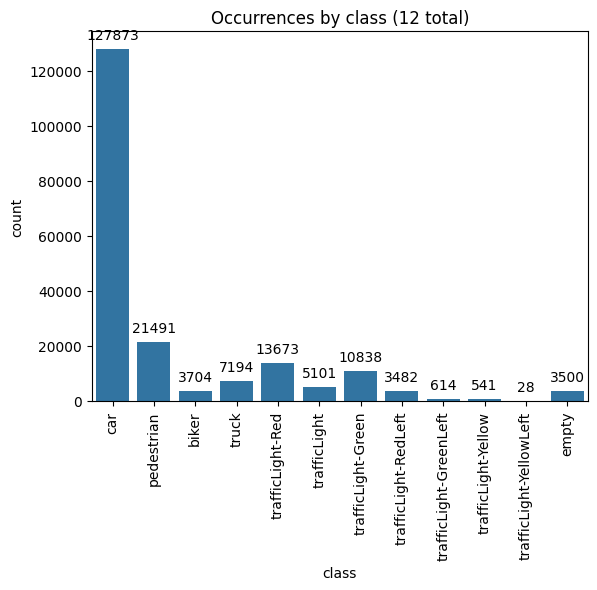

In [15]:
ax = sns.countplot(x=df_full['class'])

# Annotate counts above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count), 
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position
        ha='center', va='bottom',                         # alignment
        xytext=(0, 5), textcoords='offset points'         # offset above bar
    )

plt.xticks(rotation=90)
plt.title("Occurrences by class (12 total)")
plt.show()

Random image path: D:\Udacity_car_data\data\export\1478897707606258671_jpg.rf.WQONnzl5WluJSmjXNtmz.jpg
Image classes: ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
Image height: 512
Image width: 512


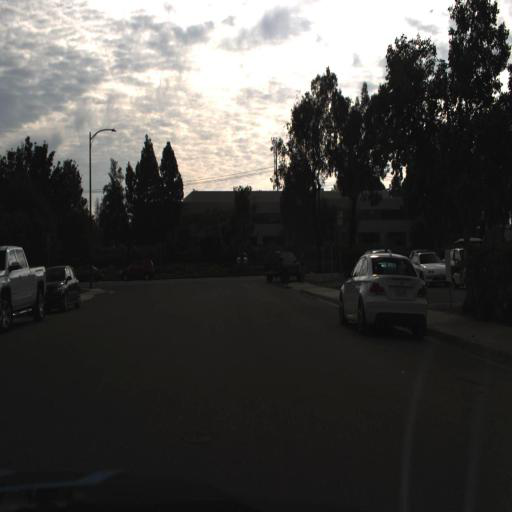

In [16]:
# Set seed
# random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
# there are 29,800 images
image_path_list = list(image_path.glob("*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_classes = df_full[df_full['filename'] == random_image_path.stem + '.jpg']['class'].to_list()

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image classes: {image_classes}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [17]:
# data transform
data_transform = transforms.Compose([
    # Resize the images to 128x128
    transforms.Resize(size=(128, 128)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

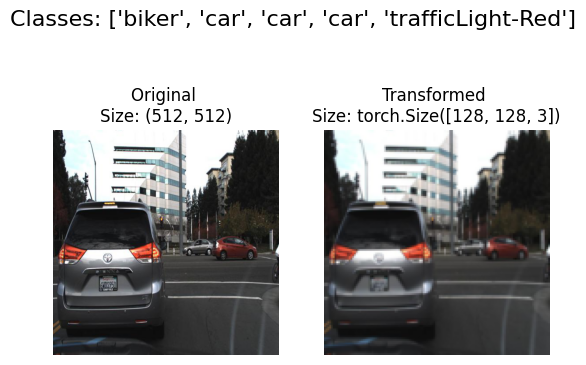

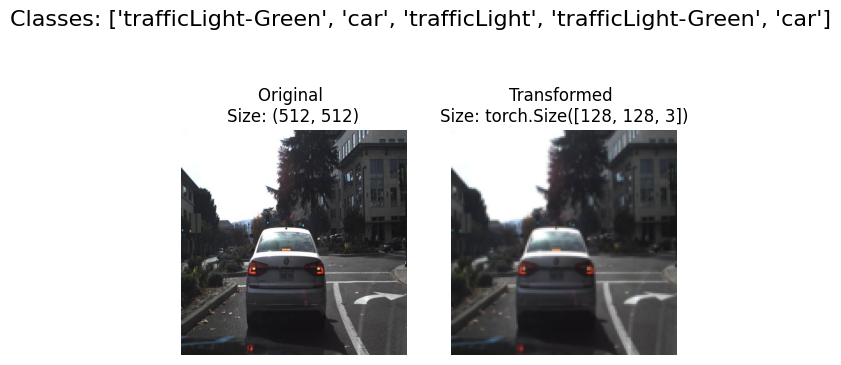

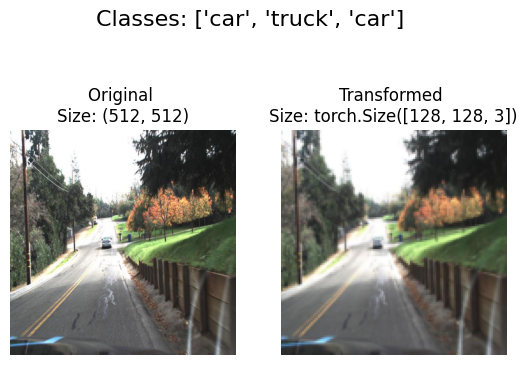

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            image_classes = df_full[df_full['filename'] == image_path.stem + '.jpg']['class'].to_list()
            fig.suptitle(f"Classes: {image_classes}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3, seed=724)

In [19]:
groups = df_full['filename']

X = df_full.drop(columns=['class'])
y = df_full['class']

sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=724)
# Take the first fold as test set
tr_idx, te_idx = next(sgkf.split(X, y, groups=groups))
X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]


print("Train size:", len(tr_idx), "Test size:", len(te_idx))
print("Test fraction:", len(te_idx) / len(X))

# Sanity check: no group overlap
print("Shared groups:", set(groups[tr_idx]) & set(groups[te_idx]))

Train size: 131680 Test size: 66359
Test fraction: 0.33508046394902014
Shared groups: set()


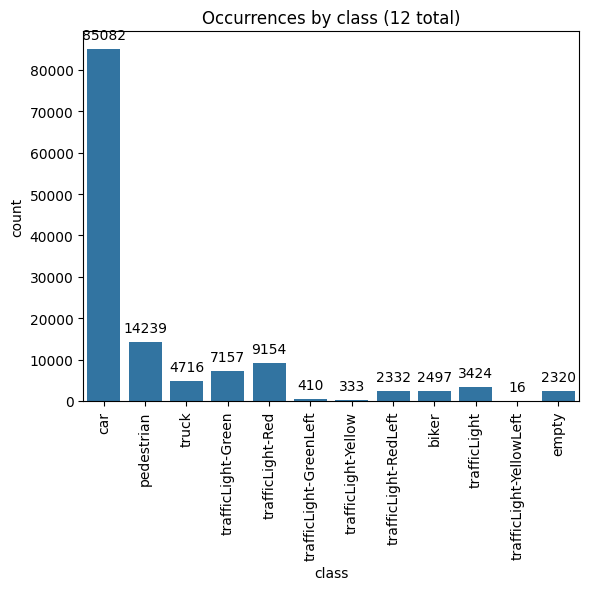

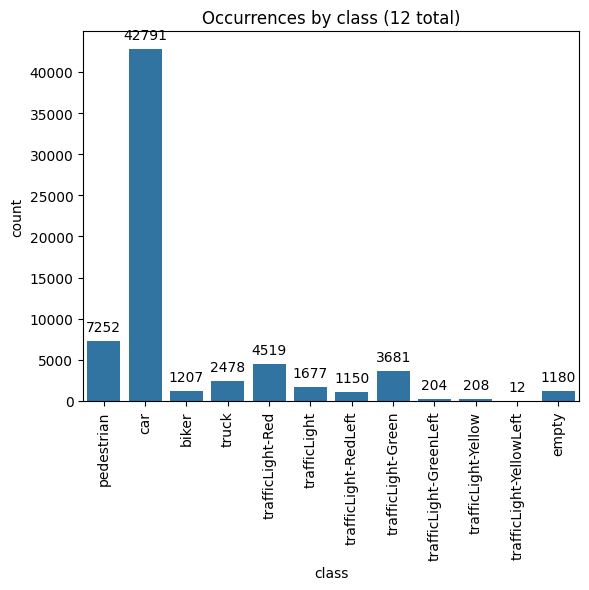

In [20]:
# training set
ax = sns.countplot(x=y_tr)

# Annotate counts above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count), 
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position
        ha='center', va='bottom',                         # alignment
        xytext=(0, 5), textcoords='offset points'         # offset above bar
    )

plt.xticks(rotation=90)
plt.title("Occurrences by class (12 total)")
plt.show()


# testing set
ax = sns.countplot(x=y_te)

# Annotate counts above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count), 
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position
        ha='center', va='bottom',                         # alignment
        xytext=(0, 5), textcoords='offset points'         # offset above bar
    )

plt.xticks(rotation=90)
plt.title("Occurrences by class (12 total)")
plt.show()

Create training/testing folders

In [21]:
# home
# train_path = r'D:/Udacity_car_data/data/train'
# test_path = r'D:/Udacity_car_data/data/test'
# laptop
# train_path = r'C:\self-driving-car\data\train'
# test_path = r'C:\self-driving-car\data\test'

train_path = folder_path / "train"
test_path = folder_path / "test"

train_path

WindowsPath('D:/Udacity_car_data/data/train')

In [52]:
# create folders if they don't exist
os.makedirs(train_path, exist_ok=False)
os.makedirs(test_path, exist_ok=False)

# create training/testing annotated files
df_full.iloc[tr_idx].to_csv(train_path + '/train_annotate.csv', index=False)
df_full.iloc[te_idx].to_csv(test_path + '/test_annotate.csv', index=False)

# copy files to train folder
for fname in X_tr['filename']:
    src_path = os.path.join(image_path, fname)
    dst_path = os.path.join(train_path, fname)

    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)   # preserves metadata
    else:
        print(f"WARNING: {fname} not found in source folder")


# copy files to test folder
for fname in X_te['filename']: 
    src_path = os.path.join(image_path, fname)
    dst_path = os.path.join(test_path, fname)

    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)   # preserves metadata
    else:
        print(f"WARNING: {fname} not found in source folder")

Create a small train/test split

In [30]:
filenames = df_full['filename'].unique()

# set seed
rng = np.random.default_rng(seed=7247)

tr_fn = rng.choice(filenames, size=400, replace=False)
te_fn = rng.choice(filenames, size=150, replace=False)

np.intersect1d(tr_fn, te_fn)

array([], dtype=object)

In [ ]:
# home
# train_path_simple = r'D:/Udacity_car_data/data/train_simple'
# test_path_simple = r'D:/Udacity_car_data/data/test_simple'
# laptop
# train_path_simple = r'C:\self-driving-car\data\train_simple'
# test_path_simple = r'C:\self-driving-car\data\test_simple'

train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"

# create folders if they don't exist
os.makedirs(train_path_simple, exist_ok=False)
os.makedirs(test_path_simple, exist_ok=False)

# create training/testing annotated files
df_full[df_full['filename'].isin(tr_fn)].to_csv(train_path_simple + '/train_annotate_simple.csv', index=False)
df_full[df_full['filename'].isin(te_fn)].to_csv(test_path_simple + '/test_annotate_simple.csv', index=False)

# copy files to train folder
for fname in df_full[df_full['filename'].isin(tr_fn)]['filename']:
    src_path = os.path.join(image_path, fname)
    dst_path = os.path.join(train_path_simple, fname)

    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)   # preserves metadata
    else:
        print(f"WARNING: {fname} not found in source folder")


# copy files to test folder
for fname in df_full[df_full['filename'].isin(te_fn)]['filename']: 
    src_path = os.path.join(image_path, fname)
    dst_path = os.path.join(test_path_simple, fname)

    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)   # preserves metadata
    else:
        print(f"WARNING: {fname} not found in source folder")

Create folder with images that only have one object

In [22]:
# list of filenames that only contain one object
one_object_filenames = []

filenames = list(an_df['filename'].unique())

for file in filenames:
    if len(an_df[an_df['filename'] == file]) == 1:
        one_object_filenames.append(file)

df_one_obj = an_df[an_df['filename'].isin(one_object_filenames)]

df_one_obj

,filename,width,height,class,xmin,ymin,xmax,ymax
116,1478901429557052708_jpg.rf.68a340e4e25dc7c833c...,512,512,car,188,249,234,306
117,1478020641213687273_jpg.rf.68403954654360d0179...,512,512,car,456,226,511,312
305,1478896093139274453_jpg.rf.68f26bc2eedd4caf2f6...,512,512,car,301,231,397,309
504,1478897678468711522_jpg.rf.69637630faca0624572...,512,512,truck,240,255,283,283
514,1478732757374463949_jpg.rf.694af5c32e341caea5b...,512,512,car,251,237,274,265
...,...,...,...,...,...,...,...,...
193905,1478896095995655629_jpg.rf.NhucWormoUT6daZ4CkL...,512,512,car,184,248,254,325
194114,1478895357890908925_jpg.rf.Ned8zwqajiww82AG6Di...,512,512,car,22,297,50,329
194170,1478899536303697697_jpg.rf.NnV0Z3CF8QJpXmMeo9W...,512,512,car,506,261,511,291
194364,1478895753794135456_jpg.rf.NnNIYgD0KW5FnMndhc8...,512,512,car,341,165,371,207


In [23]:
df_one_obj['class'].unique()

array(['car', 'truck', 'trafficLight-Red', 'biker', 'pedestrian',
       'trafficLight-Green', 'trafficLight'], dtype=object)

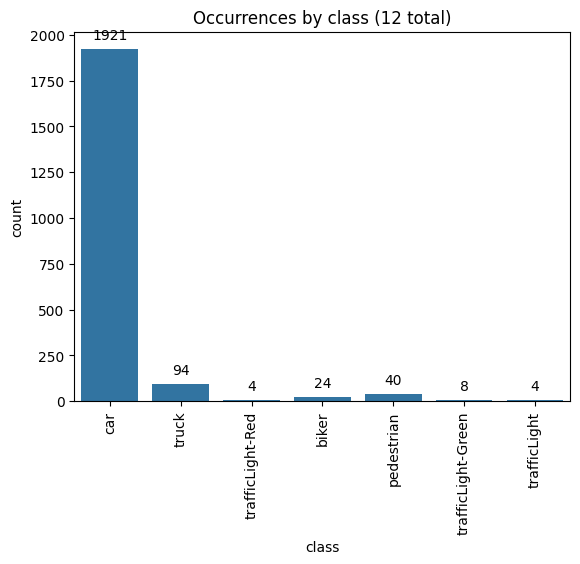

In [24]:
# 
ax = sns.countplot(x=df_one_obj['class'])

# Annotate counts above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count), 
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position
        ha='center', va='bottom',                         # alignment
        xytext=(0, 5), textcoords='offset points'         # offset above bar
    )

plt.xticks(rotation=90)
plt.title("Occurrences by class (12 total)")
plt.show()

In [29]:
groups = ['car', 'truck', 'pedestrian']

X = df_one_obj[df_one_obj['class'].isin(groups)].drop(columns=['class']).reset_index(drop=True)
y = df_one_obj[df_one_obj['class'].isin(groups)]['class'].reset_index(drop=True)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=y, random_state=724)

In [30]:
df_oo_tr = X_tr.join(y_tr)
df_oo_te = X_te.join(y_te)

df_oo_tr

,filename,width,height,xmin,ymin,xmax,ymax,class
1216,1478020634209739476_jpg.rf.ccd5b46614e1663f8ed...,512,512,306,234,356,295,car
260,1478898457707593193_jpg.rf.e351ac96075ad3ca174...,512,512,213,237,232,271,car
100,1478895469862919390_jpg.rf.7c69eb44d1cfb11e83d...,512,512,276,228,298,246,car
1430,1478020594709762265_jpg.rf.sqSTEAQ3Mt9Ga2u0qgr...,512,512,294,241,318,274,car
914,1478898880463020999_jpg.rf.4fdf3335770f3d3a95b...,512,512,118,264,151,294,car
...,...,...,...,...,...,...,...,...
1429,1478901054219761836_jpg.rf.sq7O0encesAFLvMJKfM...,512,512,414,200,455,265,truck
1524,1478900671456357785_jpg.rf.y3w4WtW1xLFXICPXEQq...,512,512,344,200,425,280,car
1893,1478899251801228287_jpg.rf.DcmzGiY6Y56UOS5OoiP...,512,512,150,237,209,322,car
1670,1478897642477246747_jpg.rf.V0L3s0WpFpk6BQwHhRR...,512,512,210,254,240,296,car


In [32]:
# home
# train_path_simple = r'D:/Udacity_car_data/data/train_simple'
# test_path_simple = r'D:/Udacity_car_data/data/test_simple'
# laptop
# train_path_one_obj = r'C:\self-driving-car\data\train_one_obj'
# test_path_one_obj = r'C:\self-driving-car\data\test_one_obj'

train_path_one_obj = folder_path / "train_one_obj"
test_path_one_obj = folder_path / "test_one_obj"

# create folders if they don't exist
os.makedirs(train_path_one_obj, exist_ok=True)
os.makedirs(test_path_one_obj, exist_ok=True)

# create training/testing annotated files
df_oo_tr.to_csv(train_path_one_obj / 'train_annotate_one_obj.csv', index=False)
df_oo_te.to_csv(test_path_one_obj / 'test_annotate_one_obj.csv', index=False)

# copy files to train folder
for fname in df_oo_tr['filename']:
    src_path = os.path.join(image_path, fname)
    dst_path = os.path.join(train_path_one_obj, fname)

    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)   # preserves metadata
    else:
        print(f"WARNING: {fname} not found in source folder")


# copy files to test folder
for fname in df_oo_te['filename']: 
    src_path = os.path.join(image_path, fname)
    dst_path = os.path.join(test_path_one_obj, fname)

    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)   # preserves metadata
    else:
        print(f"WARNING: {fname} not found in source folder")

## Load image data

In [32]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)


# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        # self.classes, self.class_to_idx = find_classes(targ_dir)
        # there should only be one .csv file in the train/test directory, so list(pathlib.Path(targ_dir).glob("*.csv"))[0] gets it!
        self.annotate_df = pd.read_csv(list(pathlib.Path(targ_dir).glob("*.csv"))[0])
        self.classes = list(self.annotate_df['class'].unique())
        self.class_to_idx = dict(zip(self.classes, range(0, 12)))

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Dict]:
        """
        Returns one sample of data, in the form img, dict, where
        img is a torch.Tensor and dict is a Dictonary of the form
        {
          "file_name": "img_0001.jpg",
          "objects": [
             {'class': '1', 'xmin': 186, 'xmax': 192, 'ymin': 251, 'ymax': 258},
             {'class': '4', 'xmin': 80, 'xmax': 85, 'ymin': 250, 'ymax': 267},
             ...
           ]
        }.
        """
        img = self.load_image(index)
        # image_path = self.paths[index]
        img_name = self.paths[index].stem + '.jpg'
        img_df = self.annotate_df[self.annotate_df['filename'] == img_name]
        img_df.loc[:, 'class'] = img_df['class'].map(self.class_to_idx)
        
        obj_dict = img_df[['class', 'xmin', 'xmax', 'ymin', 'ymax']].to_dict(orient='records')
        # class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        # class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            # is Resize part of the transform?
            resize_flag = False
            resize_index = 0
            for i, x in enumerate(self.transform.transforms):
                if x.__class__.__name__ == "Resize":
                    resize_flag = True
                    resize_index = i

            if resize_flag == False:
                return self.transform(img), {**{"file_name": img_name}, **{"objects": obj_dict}}
            else:
                for column in ['xmin', 'xmax']:
                    new_width = self.transform.transforms[resize_index].size[0]
                    img_df.loc[:, column] = img_df[column] * (new_width / img_df['width'])
                for column in ['ymin', 'ymax']:
                    new_height = self.transform.transforms[resize_index].size[1]
                    img_df.loc[:, column] = img_df[column] * (new_height / img_df['height'])
                
                obj_dict = img_df[['class', 'xmin', 'xmax', 'ymin', 'ymax']].to_dict(orient='records')

                return self.transform(img), {**{"file_name": img_name}, **{"objects": obj_dict}}

        else:
            return img, {**{"file_name": img_name}, **{"objects": obj_dict}}

In [34]:
train_data_custom = ImageFolderCustom(targ_dir=train_path_simple, transform=None)

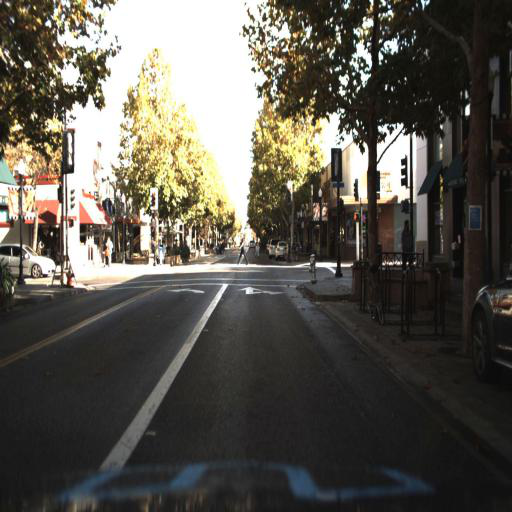

In [35]:
testimage = train_data_custom.load_image(7)

testimage

In [18]:
train_data_custom[0][1]

{'file_name': '1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.jpg',
 'objects': [{'class': 2,
   'xmin': 218.0,
   'xmax': 226.0,
   'ymin': 243.0,
   'ymax': 257.0},
  {'class': 0, 'xmin': 229.0, 'xmax': 241.0, 'ymin': 246.0, 'ymax': 260.0},
  {'class': 0, 'xmin': 253.0, 'xmax': 268.0, 'ymin': 245.0, 'ymax': 264.0},
  {'class': 1, 'xmin': 466.0, 'xmax': 485.0, 'ymin': 206.0, 'ymax': 318.0}]}

In [19]:
# data transform
new_transform = transforms.Compose([
    # Resize the images to 128x128
    transforms.Resize(size=(128, 128)),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [20]:
train_data_custom = ImageFolderCustom(targ_dir=train_path, transform=new_transform)

In [21]:
train_data_custom[0][1]

{'file_name': '1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.jpg',
 'objects': [{'class': 2,
   'xmin': 54.5,
   'xmax': 56.5,
   'ymin': 60.75,
   'ymax': 64.25},
  {'class': 0, 'xmin': 57.25, 'xmax': 60.25, 'ymin': 61.5, 'ymax': 65.0},
  {'class': 0, 'xmin': 63.25, 'xmax': 67.0, 'ymin': 61.25, 'ymax': 66.0},
  {'class': 1, 'xmin': 116.5, 'xmax': 121.25, 'ymin': 51.5, 'ymax': 79.5}]}

In [36]:
def _to_numpy(img):
    # Accept PIL, NumPy (HWC/CHW), or torch (CHW/HWC), return uint8 HWC
    if isinstance(img, Image.Image):
        arr = np.array(img)
    elif isinstance(img, np.ndarray):
        arr = img
        if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[2] not in (1, 3):
            arr = np.transpose(arr, (1, 2, 0))
    elif isinstance(img, torch.Tensor):
        t = img.detach().cpu()
        if t.ndim == 3 and t.shape[0] in (1, 3):  # CHW -> HWC
            t = t.permute(1, 2, 0)
        arr = t.numpy()
    else:
        raise TypeError(f"Unsupported image type: {type(img)}")

    if arr.dtype.kind == "f" and arr.max() <= 1.0:
        arr = (arr * 255.0).clip(0, 255).astype(np.uint8)
    elif arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    return arr


    
def show_with_box(dataset, index, color="C0", lw=2, label=False):
    
    
    arr = _to_numpy(dataset[index][0])

    fig, ax = plt.subplots()
    ax.imshow(arr)  # origin='upper' -> y downward, matches image coords

    for i in range(len(dataset[index][1]['objects'])):

        # basic sanity + clipping
        H, W = arr.shape[:2]
        x_min = dataset[index][1]['objects'][i]['xmin']
        x_max = dataset[index][1]['objects'][i]['xmax']
        y_min = dataset[index][1]['objects'][i]['ymin']
        y_max = dataset[index][1]['objects'][i]['ymax']
        x_min, y_min = max(0.0, x_min), max(0.0, y_min)
        x_max, y_max = min(W - 1, x_max), min(H - 1, y_max)
        if not (x_max > x_min and y_max > y_min):
            raise ValueError("Degenerate or inverted box after clipping.")

        
        rect = Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=lw,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        if label:
            im_label_masked = dataset[index][1]['objects'][i]['class']
            im_label = list(dataset.class_to_idx.keys())[list(dataset.class_to_idx.values()).index(im_label_masked)]
            ax.text(
                x_min, y_min,
                str(im_label),
                fontsize=10,
                color="white",
                va="top",
                ha="left",
                bbox=dict(facecolor=color, alpha=0.6, pad=2, edgecolor="none"),
            )
        ax.axis("off")

    plt.show()

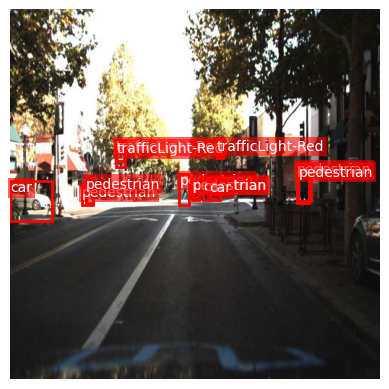

In [37]:
show_with_box(train_data_custom, 7, color='r', label=True)